# Preprocessing and clustering 3k PBMCs
v2023-11-15

We gratefully acknowledge Seurat’s and Scanpy's authors for the tutorials.

We used the same data (3k PBMCs) from a Healthy Donor, which are freely available from 10x Genomics ([download page](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). 

In [24]:
# delete the intermediate output folders to reset the tutorials
!rm -rf "data/"
!rm -rf "output/"

In [25]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data && tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz && gzip filtered_gene_bc_matrices/hg19/* && mv filtered_gene_bc_matrices/hg19/genes.tsv.gz filtered_gene_bc_matrices/hg19/features.tsv.gz
!mkdir output

--2023-11-17 23:50:14--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2023-11-17 23:50:15--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  6.40MB/s    in 1.1s    

2023-11-17 23:50:16 (6.40 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matric

In [26]:
# not use GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# import scelephant
import scelephant as el
from scelephant import RamData
import scanpy as sc

"""
configure the jupyter notebook environment
"""
el.bk.Wide( 100 ) # adjust the jupyter notebook cell width 

import matplotlib as mpl
mpl.rcParams[ "figure.dpi" ] = 100
# set image resolution

# load memory profiler 
# %load_ext memory_profiler

**Convert MTX -> RamData**

In [27]:
# initialize a pool of managed operators
fop = el.managers.FileSystemOperatorPool( 8 ) # this pool of managed operators will be used throughout the tutorials

# create RamData from 10X-formateed MTX
el.create_ramdata_from_mtx( 
    path_folder_mtx_10x_input = f'data/filtered_gene_bc_matrices/hg19/', 
    path_folder_ramdata_output = f'output/pbmc3k.ram/',
    file_system_operator_pool = fop,
)

**loading RamData**

In [28]:
ram = RamData( 
    f'output/pbmc3k.ram/', 
    int_total_weight_for_each_batch = 100_000,
    int_num_cpus = 8,
    file_system_operator_pool = fop
)

2023-11-17 23:50:27,451 [SC-Elephant] <INFO> (layer) - 'raw' layer has been loaded


**view RamData**
- JavaScript-based interactive visualization of RamData object in Jupyter Notebook

In [29]:
ram

<RamData object (2700 barcodes X 32738 features, 2286884 records in the currently active layer 'raw') stored at /home/merit_an/git/scelephant/doc/jn/tutorials/output/pbmc3k.ram/
	with the following layers : {'raw'}
		current layer is 'raw'>

**preprocessing**

2023-11-17 23:50:33,523 [SC-Elephant] <INFO> (prepare_dimension_reduction_from_raw) - [SLOW MODE] converting dense to sparse formats ... 
raw/dense > raw/sparse_for_querying_features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2286884.0/2286884 [00:01<00:00, 1830274.86it/s]
raw/dense > raw/sparse_for_querying_barcodes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2286884.0/2286884 [00:02<00:00, 1113038.66it/s]
2023-11-17

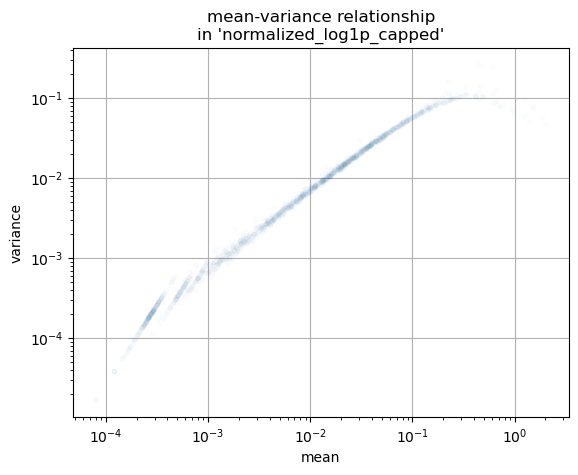

In [30]:
# analysis using fast mode
flag_use_fast_mode = False # does not generate intermediate output layers for fast analysis # you can set the flag to False to generate all intermediate layers
# preprocess outputs
ram.prepare_dimension_reduction_from_raw( 
    name_layer_raw = 'raw', # name of the input layer
    name_layer_capped = 'normalized_log1p_capped', # name of the output layer for dimension reduction
    name_layer_scaled = None, # does not perform scaling (capping is often sufficient)
    name_col_filter_filtered_barcode = 'filtered_barcodes', # the name of the 'barcode' axis filter that will contain filtered cells
    min_counts = 500, # cell filtering criteria
    min_features = 200, 
    int_total_count_target = 10_000, # target count for normalization
    int_num_highly_variable_features = 2_000, # the number of the highly-variable features for performing dimension reduction
    name_col_filter_highly_variable = 'filter_normalized_log1p_highly_variable_2000', # the name of the 'feature' axis filter that will contain detected highly variable features
    max_value = 10, 
    dict_kw_hv = { 'float_min_mean' : 0.01, 'float_min_variance' : 0.01 }, 
    flag_use_fast_mode = flag_use_fast_mode,
)

**prepare dimension reduction**

2023-11-17 23:51:40,156 [SC-Elephant] <WARNING> (train_pca) - iPCA model 'ipca' does not exist in the RamData models database, initializing the model.
30 PCs from 1999 features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:20<00:00, 133.68it/s]
2023-11-17 23:52:01,670 [SC-Elephant] <INFO> (train_pca) - fit completed
2023-11-17 23:52:01,689 [SC-Elephant] <INFO> (load_str) - [Axis features] completed loading of 1999 number of strings
2023-11-17 23:52:01,711 [SC-Elephant] <INFO> (load_str) - [Axis features] completed loading of 1999 number of strings
2023-11-17 23:52:01,964 [SC-Elephant] <INFO> (save_model) - ipca|ipca model saved.
30 PCs from 1999 features: 100%

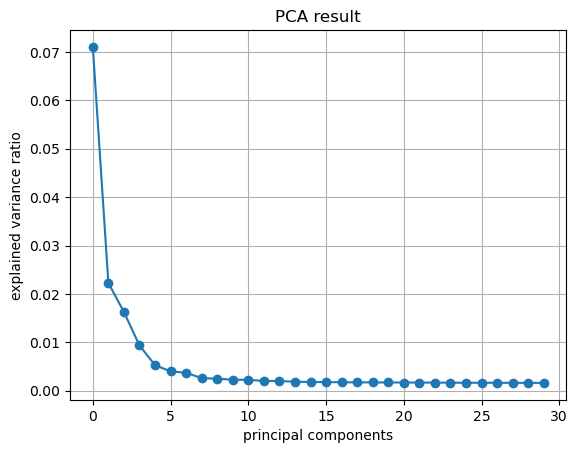

In [31]:
# perform UMAP embedding
ram.perform_dimension_reduction_and_clustering(
    name_layer_pca = 'normalized_log1p_capped', 
    name_filter_barcodes = 'filtered_barcodes',
    name_filter_features = 'filter_normalized_log1p_highly_variable_2000',
    str_embedding_method = 'scanpy-umap', # use scanpy functions to generate umap and leiden clustering results
    float_prop_subsampling_pca = 1, # use all cells without subsampling
    dict_kw_for_run_scanpy_using_pca = {
        'int_neighbors_n_neighbors': 30, 
        'int_neighbors_n_pcs': 30, 
        'set_method': {'umap', 'leiden'}, # run umap and leiden 
        'dict_kw_leiden': {'resolution': 0.5}, 
    },
)

2023-11-17 23:53:35,874 [SC-Elephant] <INFO> (load_str) - [Axis barcodes] completed loading of 2700 number of strings
2023-11-17 23:53:35,932 [SC-Elephant] <INFO> (load_str) - [Axis features] completed loading of 32738 number of strings
2023-11-17 23:53:35,959 [SC-Elephant] <INFO> (__getitem__) - l = ['str']
2023-11-17 23:53:35,960 [SC-Elephant] <INFO> (__getitem__) - l = ['str', 'leiden_scanpy', {'X_umap_scanpy', 'X_pca'}]


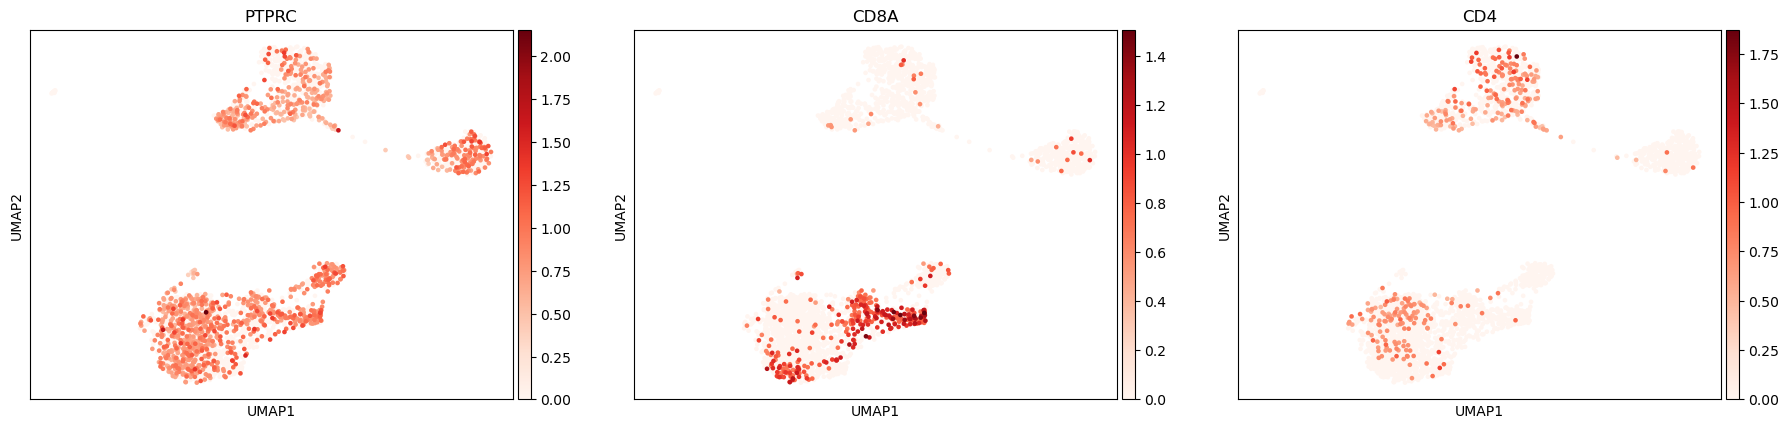

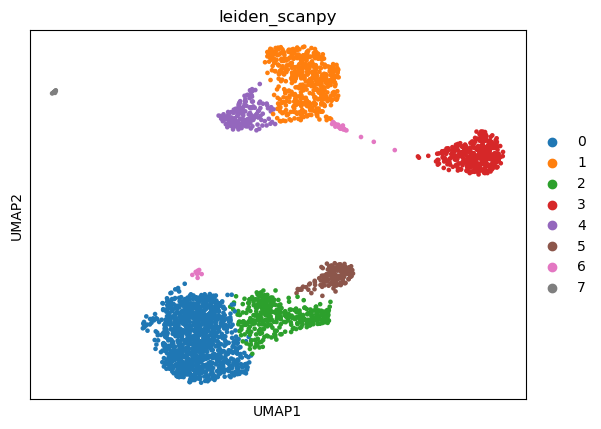

In [32]:
import scanpy as sc
# retrieve anndata 
ram.ft.filter = None # reset the filter
adata = ram[
    'normalized_log1p_capped',
    :,
    [ 'str', 'leiden_scanpy', { 'X_pca', 'X_umap_scanpy' } ],
    [ 'PTPRC', 'CD8A', 'CD4' ],
    [ 'str' ]
]
adata.obsm[ 'X_umap' ] = adata.obsm[ 'X_umap_scanpy' ]

# plot gene expression values
sc.pl.umap( adata, color = [ 'PTPRC', 'CD8A', 'CD4' ], cmap = 'Reds' )

# plot leiden clustering result
dict_color_ori = {'0': '#1f77b4', '1': '#ff7f0e', '2': '#2ca02c', '3': '#d62728', '4': '#9467bd', '5': '#8c564b', '6': '#e377c2', '7': '#7f7f7f' } # colors of the original annotations

sc.pl.umap( adata, color = 'leiden_scanpy' )
# done!